In [29]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [30]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [31]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

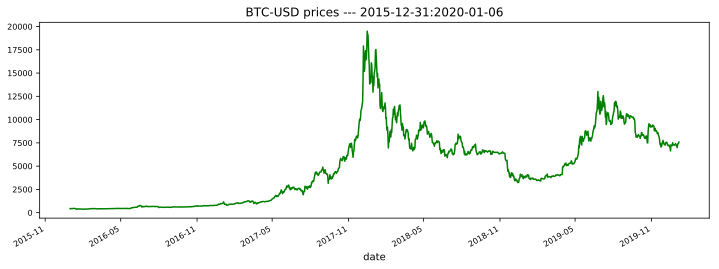

In [94]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2020-01-06', 
                  freq='daily', 
                  path='data/BTC.csv')

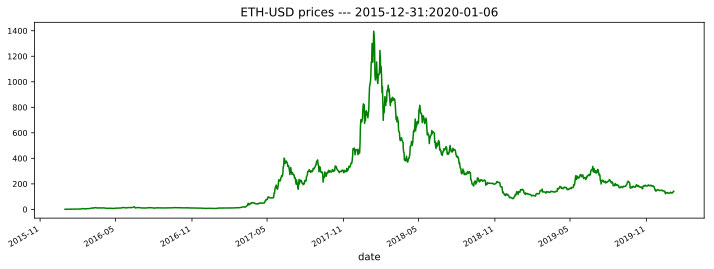

In [95]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-12-31', 
                  end_date='2020-01-06', 
                  freq='daily', 
                  path='data/ETH.csv')

In [100]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [101]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                  open       close
date                              
2015-12-31  430.566986  430.566986
2016-01-01  434.334015  434.334015
2016-01-02  433.437988  433.437988
2016-01-03  430.010986  430.010986
2016-01-04  433.091003  433.091003
                open     close
date                          
2015-12-31  0.933542  0.933542
2016-01-01  0.948024  0.948024
2016-01-02  0.937124  0.937124
2016-01-03  0.971905  0.971905
2016-01-04  0.954480  0.954480


In [102]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1468 (major_axis) x 2 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2020-01-06 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [103]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH
BTC,1.000000,0.755918
ETH,0.755918,1.000000


# Risk

### Определяем стартовые переменные

In [104]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [105]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in tqdm(range(num_assets)):
    WEIGHTS = [0] * num_assets
    WEIGHTS[single_portfolio] = 1
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        #set_benchmark(symbol('BTC'))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.time = 0
        
    
    def handle_data(context, data):
    
        if context.time == 0:

            # extract prices
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])

            context.time += 1
    
    perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2020, 1, 6, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=100000000,
                                  handle_data=handle_data,
                                  data=panel)

    performance_list.append(perf)    
        
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
    port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
    port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
    stock_weights.append(WEIGHTS)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


# Визуализация результатов

In [106]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [107]:
df.head()

,Returns,Volatility,Sharpe Ratio,BTC,ETH
0,104.580383,74.303256,1.33430,1,0
1,250.247561,125.559065,1.59072,0,1


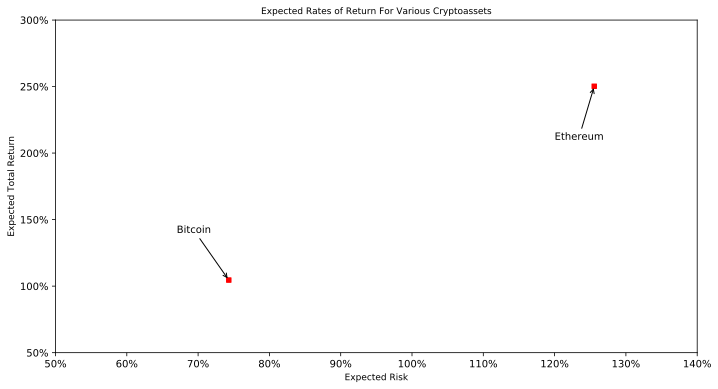

In [108]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return For Various Cryptoassets', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 140), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(67, 140),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(120, 210),
             arrowprops=dict(arrowstyle="->"))

plt.show()

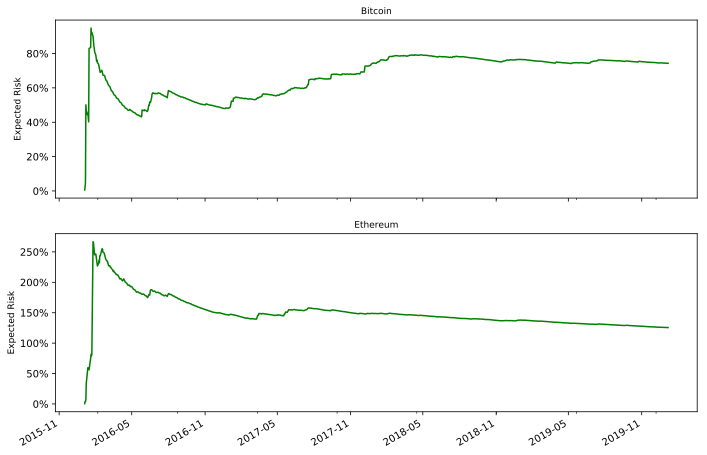

In [109]:
risk_list = []

fig, ax = plt.subplots(2, 1, sharex=True, figsize=[11.5, 8])

risk_list.append(performance_list[0].algo_volatility * 100)
risk_list[0].plot(ax=ax[0], color='g')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].set_ylabel('Expected Risk', fontsize = 9)
ax[0].set_title('Bitcoin', fontsize = 9)

risk_list.append(performance_list[1].algo_volatility * 100)
risk_list[1].plot(ax=ax[1], color='g')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].set_ylabel('Expected Risk', fontsize = 9)
ax[1].set_title('Ethereum', fontsize = 9)

#plt.legend()
plt.show()